## INSTALL TENSORFLOW

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_segar = '/content/drive/MyDrive/dataset-segarin-new/train/segar'
train_busuk = '/content/drive/MyDrive/dataset-segarin-new/train/busuk'
test_segar = '/content/drive/MyDrive/dataset-segarin-new/validation/segar'
test_busuk = '/content/drive/MyDrive/dataset-segarin-new/validation/busuk'

In [ ]:
import os
train_segar_names = os.listdir(train_segar)
train_busuk_names = os.listdir(train_busuk)
test_segar_names = os.listdir(test_segar)
test_busuk_names = os.listdir(test_busuk)

In [ ]:
print(len(train_segar_names))
print(len(train_busuk_names))
print(len(test_segar_names))
print(len(test_busuk_names))

215
218
91
93


## BUILDING THE MODEL

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
base_model = InceptionV3(input_shape=(256,256,3), include_top = False)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(units=2, activation='sigmoid')(x)

#Final model
model = Model(base_model.input, x)
model.compile(optimizer= 'adam', loss = tensorflow.keras.losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

## PREPROCESSING DATASET

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_data = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset-segarin-new/train',
                                               class_mode='categorical',
                                               target_size=(256,256),
                                               batch_size=32)

Found 430 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'busuk': 0, 'segar': 1}

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset-segarin-new/validation',
                                                 class_mode = 'categorical',
                                                 target_size=(256,256),
                                                 batch_size=32)

Found 182 images belonging to 2 classes.


In [ ]:
test_data.class_indices

{'busuk': 0, 'segar': 1}

In [ ]:
#visualizing the data
t_img, label = train_data.next()
t_img

t_img, label = test_data.next()
t_img

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


array([[[[0.28627452, 0.2509804 , 0.13725491],
         [0.28627452, 0.2509804 , 0.13725491],
         [0.29803923, 0.2627451 , 0.14901961],
         ...,
         [0.3254902 , 0.3137255 , 0.38823533],
         [0.32156864, 0.30980393, 0.38431376],
         [0.32156864, 0.30980393, 0.38431376]],

        [[0.28627452, 0.2509804 , 0.13725491],
         [0.28627452, 0.2509804 , 0.13725491],
         [0.29803923, 0.2627451 , 0.14901961],
         ...,
         [0.48235297, 0.48627454, 0.5686275 ],
         [0.4784314 , 0.48235297, 0.5647059 ],
         [0.4784314 , 0.48235297, 0.5647059 ]],

        [[0.28235295, 0.24705884, 0.13333334],
         [0.29411766, 0.25882354, 0.14509805],
         [0.29803923, 0.2627451 , 0.14901961],
         ...,
         [0.69803923, 0.7254902 , 0.8352942 ],
         [0.69803923, 0.7254902 , 0.8352942 ],
         [0.6862745 , 0.7137255 , 0.8235295 ]],

        ...,

        [[0.54509807, 0.6039216 , 0.6784314 ],
         [0.5686275 , 0.627451  , 0.7019608 ]

In [ ]:
t_img.shape

(32, 256, 256, 3)

In [ ]:
def plotImages(img_arr, label):
  for idx , img in enumerate(img_arr):
    if idx <= 10 :
      plt.figure(figsize= (5,5))
      plt.imshow(img)
      plt.title(img.shape)
      plt.axis = False
      plt.show()

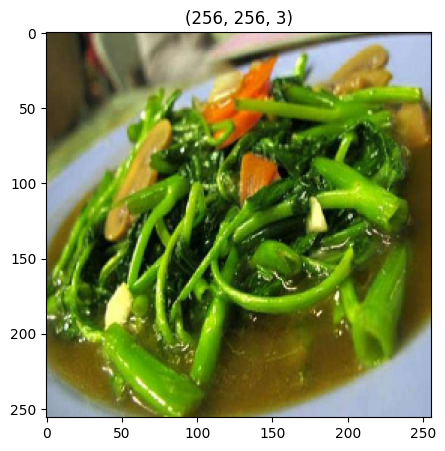

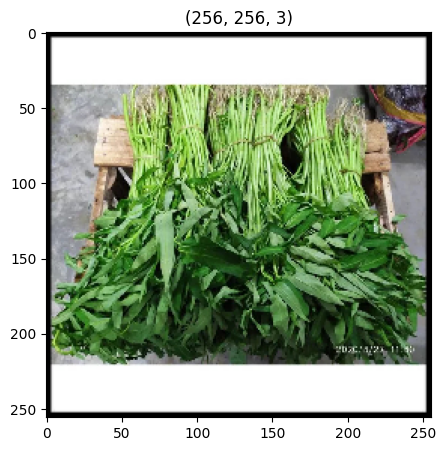

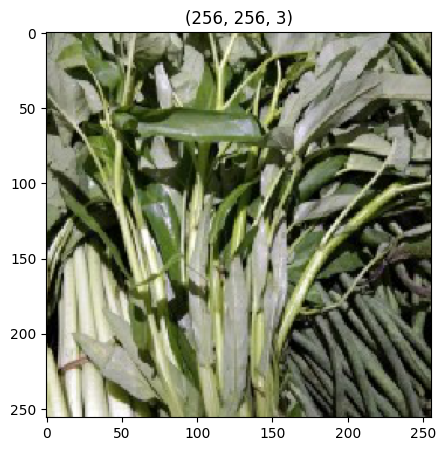

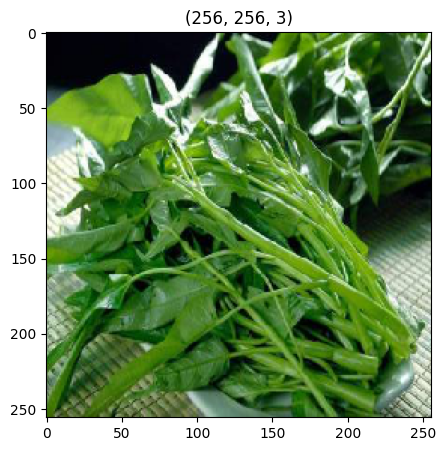

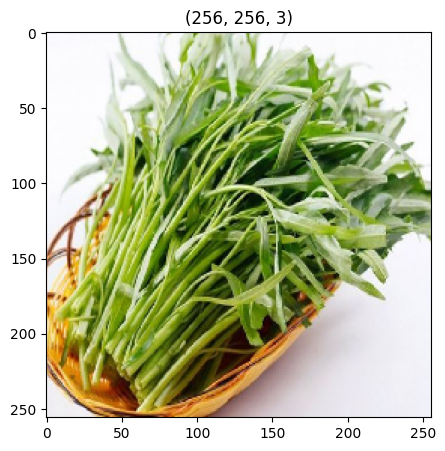

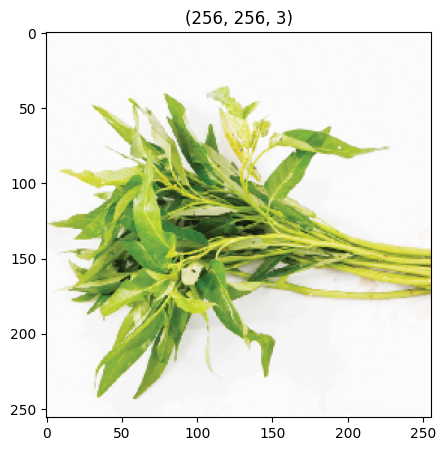

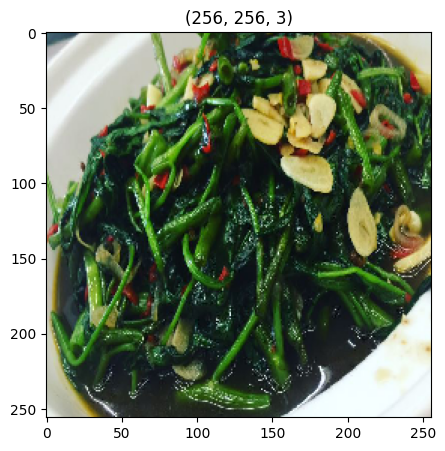

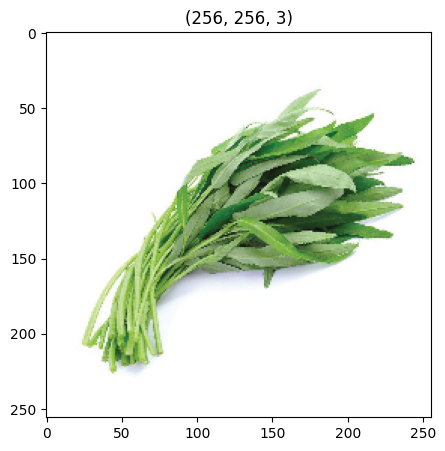

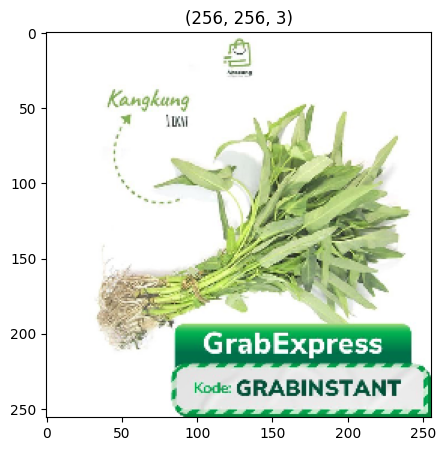

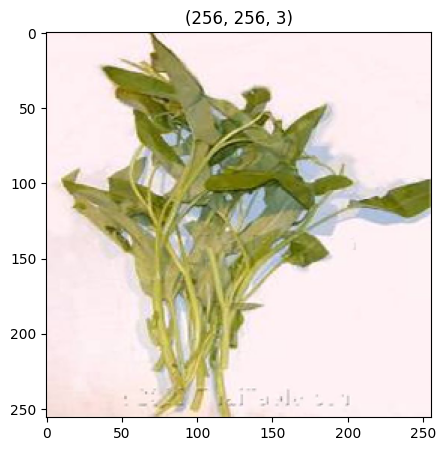

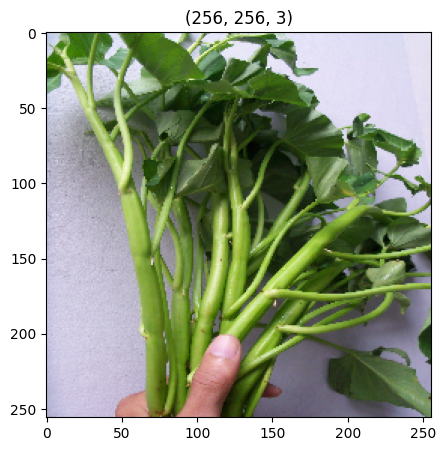

In [ ]:
plotImages(t_img , label)

## CALLBACK AND TRAINING THE MODEL

In [ ]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print('Accuracy above 95% -- Stopping Training')
            self.model.stop_training = True #stops model training

callbacks = CustomCallback()

history = model.fit_generator(train_data,
                         validation_data = test_data,
                         steps_per_epoch= 10,
                         epochs=50,
                         verbose = 1,
                         callbacks= [callbacks])

<ipython-input-20-37825419a70b>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/50
10/10 [==============================] - 108s 11s/step - loss: 3.0468 - accuracy: 0.6156 - val_loss: 2.1035 - val_accuracy: 0.7198
Epoch 2/50
10/10 [==============================] - 97s 10s/step - loss: 1.8307 - accuracy: 0.7550 - val_loss: 1.8255 - val_accuracy: 0.6703
Epoch 3/50
10/10 [==============================] - 95s 10s/step - loss: 1.4538 - accuracy: 0.7318 - val_loss: 1.8513 - val_accuracy: 0.6429
Epoch 4/50
10/10 [==============================] - 97s 10s/step - loss: 1.1178 - accuracy: 0.7748 - val_loss: 1.4091 - val_accuracy: 0.7033
Epoch 5/50
10/10 [==============================] - 101s 10s/step - loss: 0.9153 - accuracy: 0.7812 - val_loss: 1.4776 - val_accuracy: 0.6758
Epoch 6/50
10/10 [==============================] - 99s 10s/step - loss: 0.8916 - accuracy: 0.7937 - val_loss: 1.1563 - val_accuracy: 0.7308
Epoch 7/50
10/10 [==============================] - 100s 10s/step - loss: 0.8095 - accuracy: 0.8179 - val_loss: 1.3043 - val_accuracy: 0.6813
Epoch 8/50

In [ ]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and validation loss')

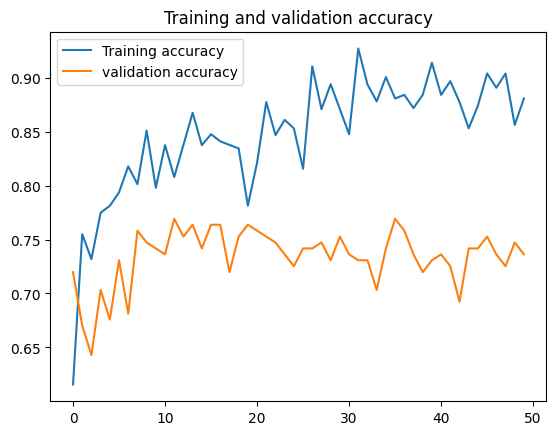

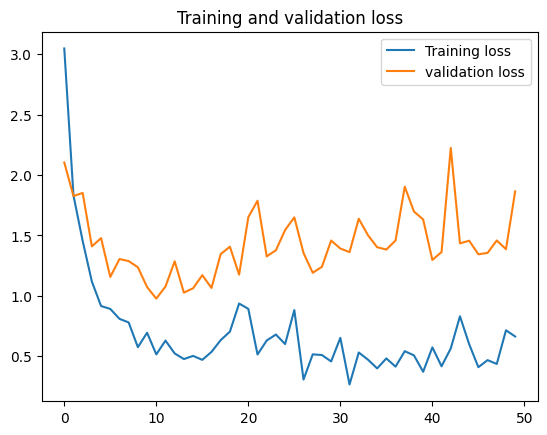

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="Training accuracy")
plt.plot(epochs, val_acc,label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="Training loss")
plt.plot(epochs, val_loss,label="validation loss")
plt.legend()
plt.title('Training and validation loss')

## TESTING THE MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from google.colab import files
#from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  output_class= np.argmax(classes)
  classname = ['Busuk', 'Segar']
  print("The predicted class is", classname[output_class])

Saving imagesb3.jpg to imagesb3.jpg
Saving imagesb2.jpg to imagesb2.jpg
Saving downloadb1.jpg to downloadb1.jpg
Saving download3.jpg to download3.jpg
Saving download2.jpg to download2.jpg
Saving download1.jpg to download1.jpg
1/1 [==============================] - 2s 2s/step
imagesb3.jpg
[[0.9979046  0.19835608]]
The predicted class is Busuk
1/1 [==============================] - 0s 292ms/step
imagesb2.jpg
[[9.9999076e-01 5.2175840e-04]]
The predicted class is Busuk
1/1 [==============================] - 0s 333ms/step
downloadb1.jpg
[[0.9992006  0.10011127]]
The predicted class is Busuk
1/1 [==============================] - 0s 296ms/step
download3.jpg
[[1.1113057e-07 1.0000000e+00]]
The predicted class is Segar
1/1 [==============================] - 0s 302ms/step
download2.jpg
[[0.86230105 0.49349934]]
The predicted class is Busuk
1/1 [==============================] - 0s 301ms/step
download1.jpg
[[0.3303022  0.99707735]]
The predicted class is Segar


## SAVING THE MODEL

In [ ]:
model.save('model_kangkung_R1.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs